In [1]:
import warnings
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from numpy.polynomial.polynomial import Polynomial
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from utilities import (
    CUSHIONS_COLS,
    DATE_GROUPINGS,
    DYESTUFF_COLS,
    EXOTIC_COLS,
    FAITH_ENCODINGS,
    FULL_OBJECT_COLS,
    GENDER_ENCODINGS,
    LINEN_COLS,
    OBJECT_COLS,
    OTHER_OBJECTS_COLS,
    WEAPONS_AND_ARMOR_COLS,
)

warnings.filterwarnings('ignore')


In [2]:
# Load dataset
df = pd.read_csv('data/dataset.csv')

# Melt to long format
df_long = df.melt(
    id_vars=['id', 'date_group', 'object_phrases'],
    value_vars=OBJECT_COLS,
    var_name='object_type',
    value_name='present',
)
df_long_full = df.melt(
    id_vars=['id', 'date_group', 'object_phrases'],
    value_vars=FULL_OBJECT_COLS,
    var_name='object_type',
    value_name='present',
)

# Group by date_group and object_type
dategroup = df_long.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)
dategroup_full = df_long_full.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)


# Compare intuitive perception of household wealth against presumed metrics

This analysis looks at how an intuitive assessment of a household's wealth (`wealth_points`) compares to previously assumed objective metrics, namely the number of object phrases in the inventory (`object_phrases`) and the quantity of linens stored in the household (`total_linens`).


Correlation Results with P-Values:


,Column 1,Column 2,Correlation,P-Value
0,wealth_points,object_phrases,0.829664,5.646820e-23
1,wealth_points,total_linens,0.799579,2.701631e-20
2,object_phrases,wealth_points,0.829664,5.646820e-23
3,object_phrases,total_linens,0.760244,2.081071e-17
4,total_linens,wealth_points,0.799579,2.701631e-20
5,total_linens,object_phrases,0.760244,2.081071e-17


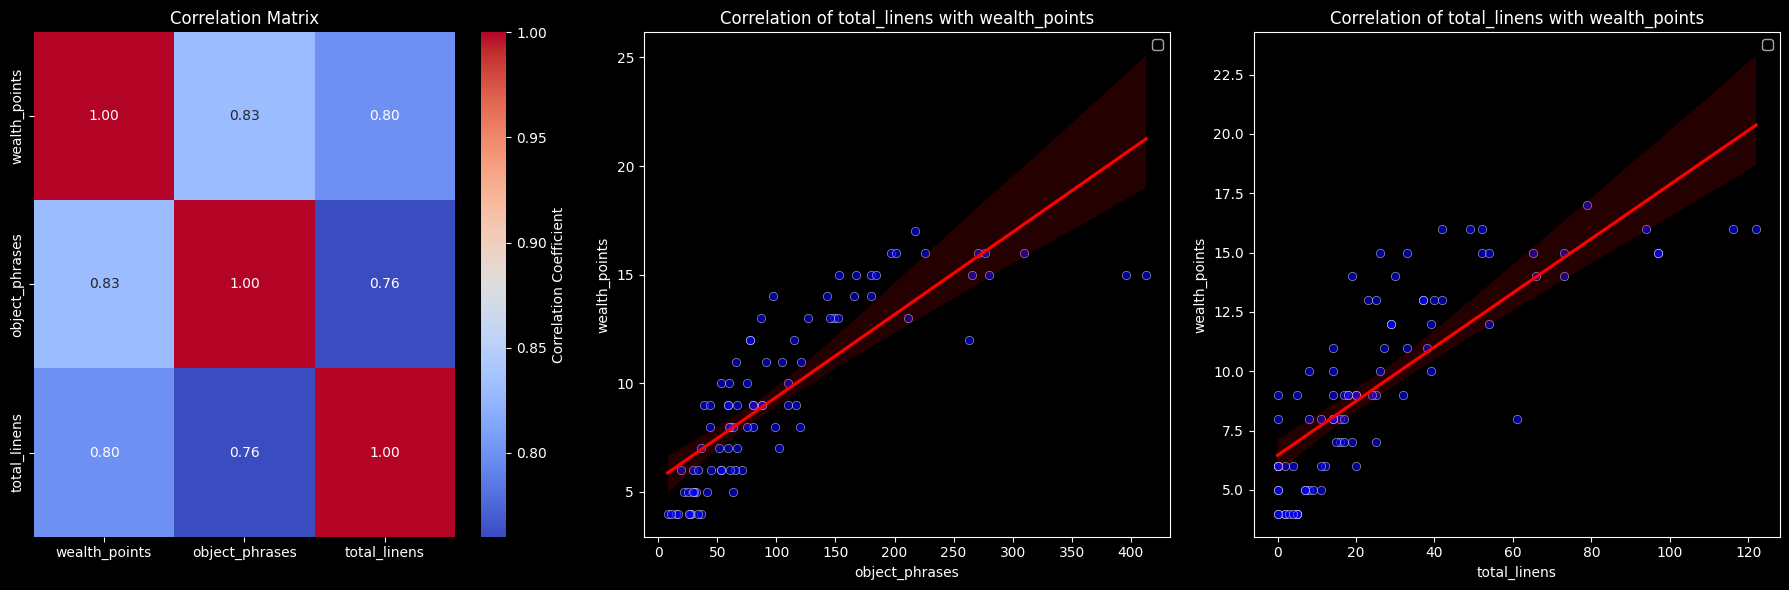

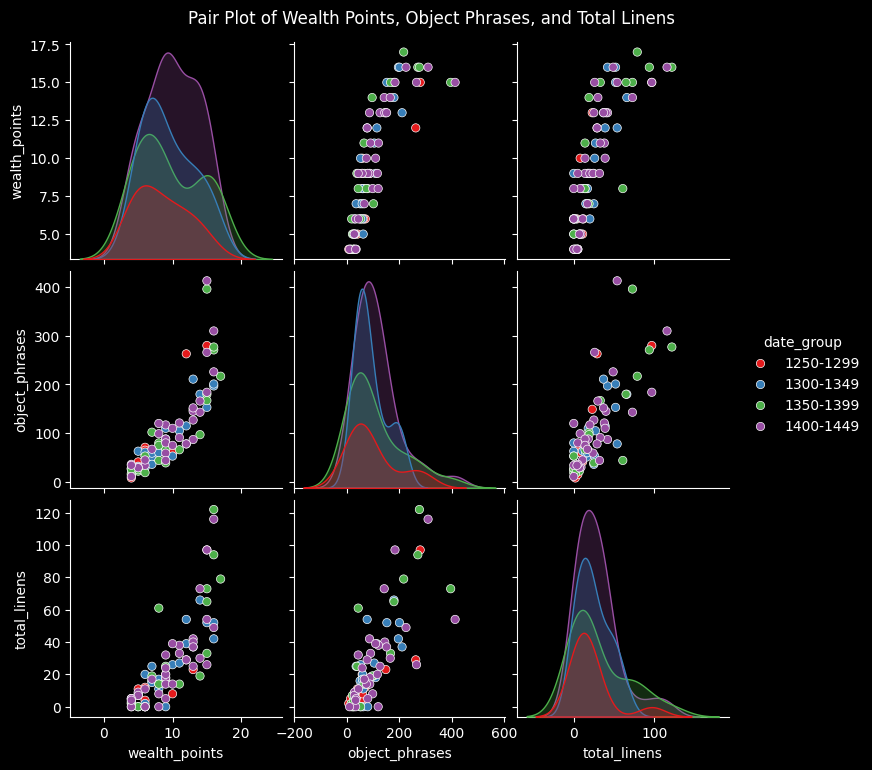

In [3]:
# Analyze correlation with p-values between object_phrases, wealth_quartile, and wealth_points
columns_to_correlate = ['wealth_points', 'object_phrases', 'total_linens']
correlation_results = []

# Calculate correlation coefficients and p-values
for col1 in columns_to_correlate:
    for col2 in columns_to_correlate:
        if col1 != col2:
            corr, p_value = pearsonr(df[col1], df[col2])
            correlation_results.append({'Column 1': col1, 'Column 2': col2, 'Correlation': corr, 'P-Value': p_value})

# Convert results to DataFrame
correlation_results_df = pd.DataFrame(correlation_results)

# Display correlation results
print('Correlation Results with P-Values:')
display(correlation_results_df)

# Visualize results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Correlation matrix
correlation_matrix = df[columns_to_correlate].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar_kws={'label': 'Correlation Coefficient'},
    ax=axes[0],
)
axes[0].set_title('Correlation Matrix')

# Visualize individual correlations
for i, col in enumerate(['object_phrases', 'total_linens'], start=1):
    sns.scatterplot(data=df, x=col, y='wealth_points', ax=axes[i], color='blue', alpha=0.6)
    sns.regplot(
        data=df, x=col, y='wealth_points', ax=axes[i], scatter=False, color='red', line_kws={'label': 'Trendline'}
    )
    axes[i].set_title(f'Correlation of {col1} with wealth_points')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('wealth_points')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Pair Plot: Visualize pairwise relationships between variables
sns.pairplot(
    df[['wealth_points', 'object_phrases', 'total_linens', 'date_group']],
    diag_kind='kde',
    corner=False,
    hue='date_group',
    palette='Set1',
)
plt.suptitle('Pair Plot of Wealth Points, Object Phrases, and Total Linens', y=1.02)
plt.show()


## Interpretation

All correlations are strong and statistically significant, with p-values far below 0.05. The `wealth_points` value is strongly correlated with both `object_phrases` and `total_linens`, indicating that both are good indicators of wealth.
The strong correlation between `object_phrases` and `total_linens` further reinforces the idea that linens are a key component of household wealth as measured by the number of objects.

**wealth_points and object_phrases:**
- Correlation: 0.830 (strong positive correlation)
- P-Value: 5.65e-23 (highly statistically significant)

**estimated_wealth_points and total_linens:**
- Correlation: 0.800 (strong positive correlation)
- P-Value: 2.70e-20 (highly statistically significant)

**object_phrases and total_linens:**
- Correlation: 0.760 (strong positive correlation)
- P-Value: 2.08e-17 (highly statistically significant)


# How do `object_phrases` and `wealth_points` behave across time?


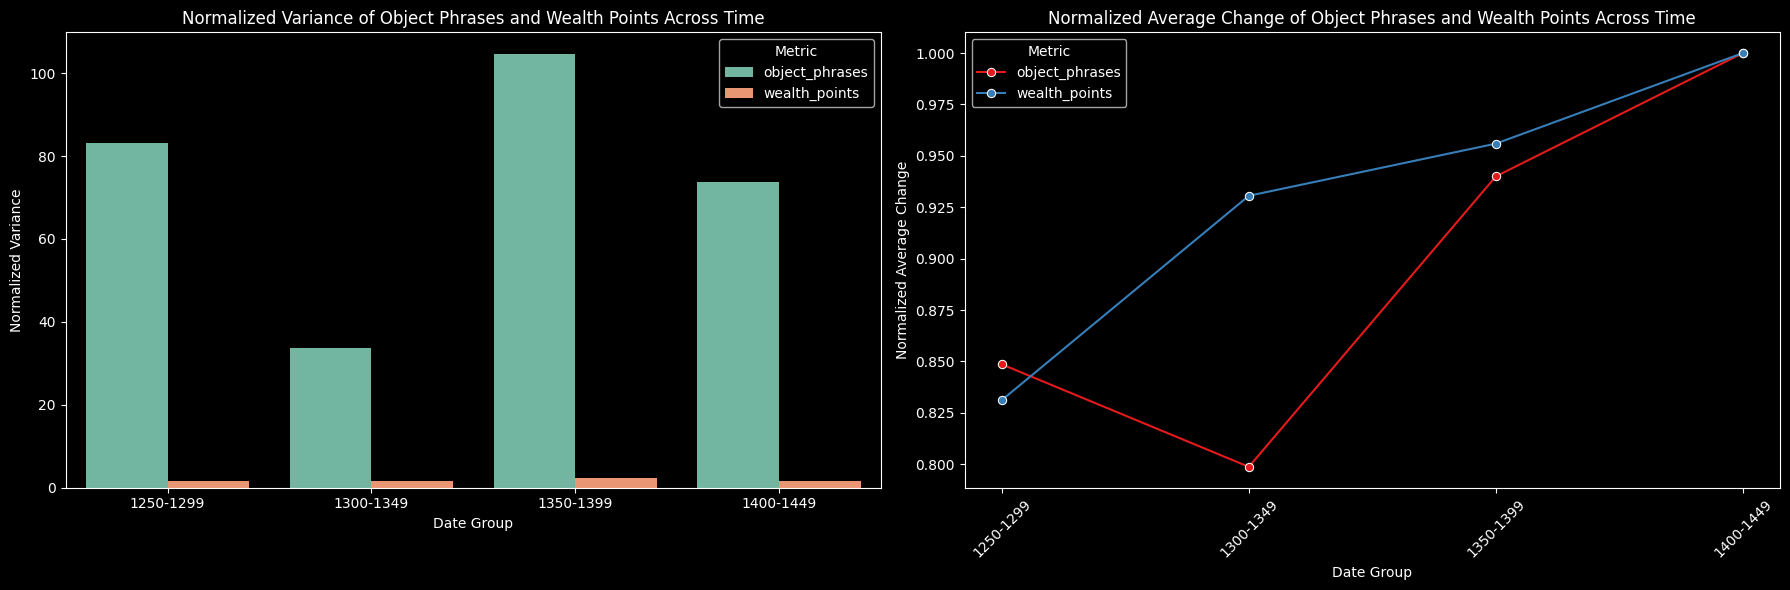

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Compare variance across time between 'object_phrases' and 'wealth_points' across 'DATE_GROUPINGS'
df['date_group'] = df['year'].apply(
    lambda x: next((group for group, years in DATE_GROUPINGS.items() if x in years), 'Unknown')
    if 'year' in df.columns
    else 'Unknown'
)

# Group by 'date_group' and calculate variance
variance_df = df.groupby('date_group')[['object_phrases', 'wealth_points']].var().reset_index()

# Normalize variance by dividing by the mean of each column
mean_values = df[['object_phrases', 'wealth_points']].mean()
variance_df[['object_phrases', 'wealth_points']] = variance_df[['object_phrases', 'wealth_points']].div(
    mean_values, axis=1
)

# Plot normalized variance comparison
sns.barplot(
    data=variance_df.melt(id_vars='date_group', var_name='Metric', value_name='Normalized Variance'),
    x='date_group',
    y='Normalized Variance',
    hue='Metric',
    palette='Set2',
    ax=axes[0],
)
axes[0].set_title('Normalized Variance of Object Phrases and Wealth Points Across Time')
axes[0].set_xlabel('Date Group')
axes[0].set_ylabel('Normalized Variance')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()


# Compare average change across time between 'object_phrases' and 'wealth_points'
# Calculate average change for each metric within each date group
average_change_df = df.groupby('date_group')[['object_phrases', 'wealth_points']].mean().reset_index()

# Normalize the average change by dividing by the maximum value of each column
max_values = average_change_df[['object_phrases', 'wealth_points']].max()
average_change_df[['object_phrases', 'wealth_points']] = average_change_df[['object_phrases', 'wealth_points']].div(
    max_values,
    axis=1,
)

# Plot normalized average change comparison
sns.lineplot(
    data=average_change_df.melt(id_vars='date_group', var_name='Metric', value_name='Normalized Average Change'),
    x='date_group',
    y='Normalized Average Change',
    hue='Metric',
    marker='o',
    palette='Set1',
    ax=axes[1],
)
axes[1].set_title('Normalized Average Change of Object Phrases and Wealth Points Across Time')
axes[1].set_xlabel('Date Group')
axes[1].set_ylabel('Normalized Average Change')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Interpretation

The period 1350-1399 stands out with the highest variance in both `object_phrases` and `wealth_points`, indicating significant changes or disparities during this time.
Variance in `object_phrases` is consistently higher than in `wealth_points`, suggesting that household inventories were more diverse than wealth distribution across all periods.
The stabilization of `wealth_points` variance in 1400-1449 may reflect economic recovery or consolidation after a period of upheaval.

**1250-1299**
- `object_phrases` variance: 8733.67 (high variability in the number of object phrases, indicating diverse household inventories during this period).
- `wealth_points` variance: 14.25 (relatively low variability, suggesting more consistent wealth distribution).

**1300-1349**
- `object_phrases` variance: 3532.02 (significant drop in variability compared to the previous period, indicating more uniform household inventories).
- `wealth_points` variance: 13.96 (similar to the previous period, showing consistent wealth distribution).

**1350-1399**
- `object_phrases` variance: 10987.45 (sharp increase in variability, suggesting a period of significant diversity in household inventories).
- `wealth_points` variance: 21.15 (highest variability across all periods, reflecting greater economic disparities or changes in wealth distribution).

**1400-1449**
- `object_phrases` variance: 7743.49 (decrease from the previous period but still relatively high, indicating continued diversity in inventories).
- `wealth_points` variance: 13.99 (return to lower variability, suggesting a stabilization in wealth distribution).



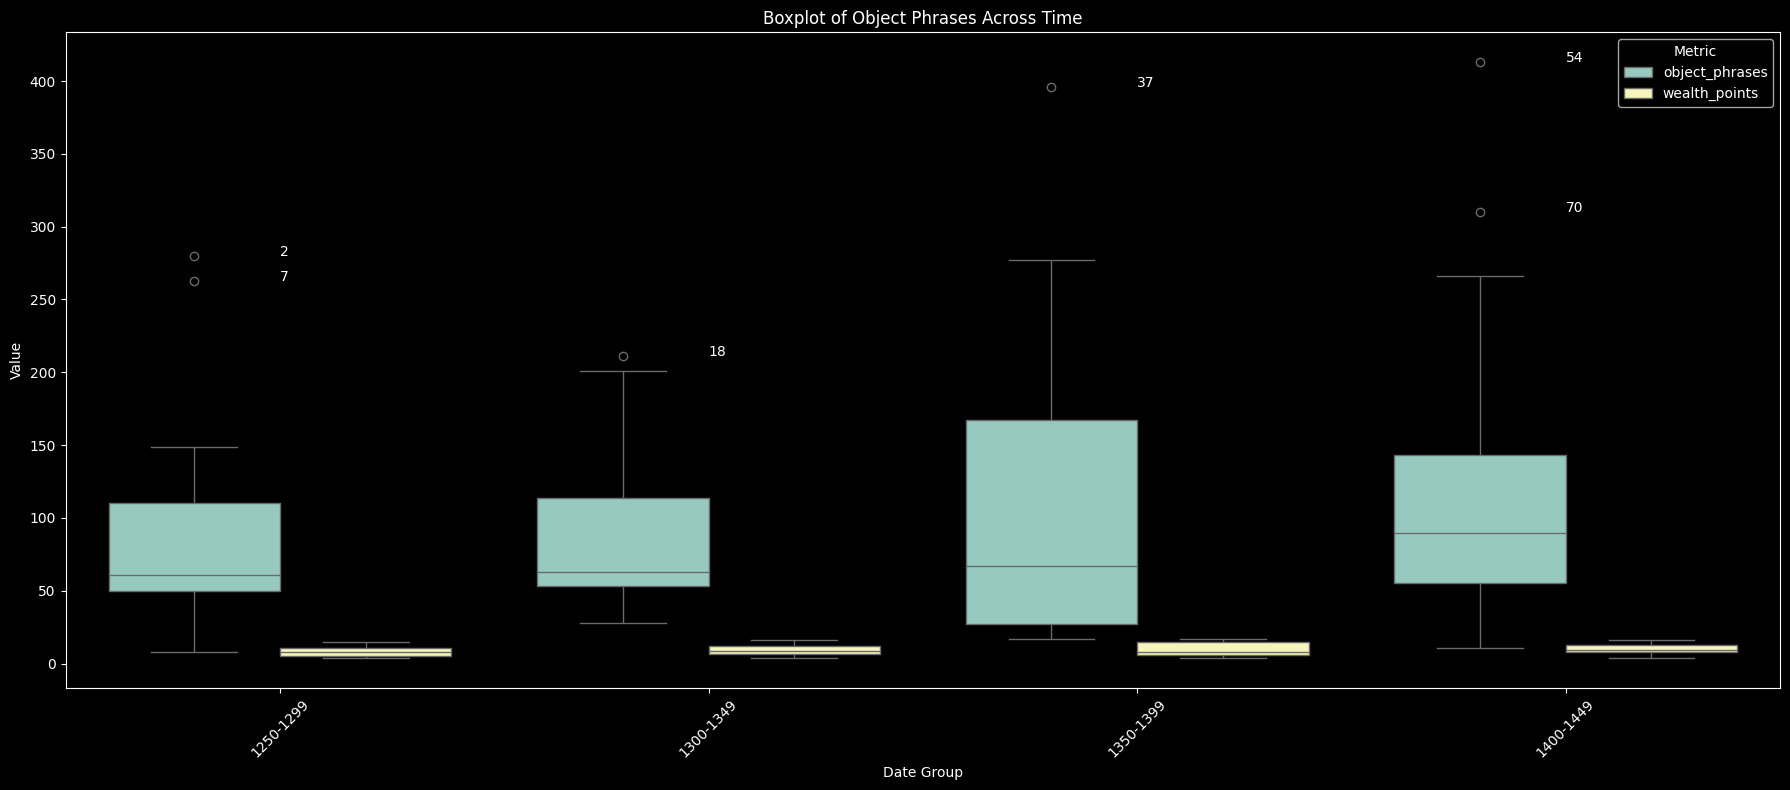

In [5]:
plt.figure(figsize=(18, 8))
sns.boxplot(
    data=df.melt(
        id_vars=['id', 'date_group'],
        value_vars=['object_phrases', 'wealth_points'],
        var_name='Metric',
        value_name='Value',
    ),
    x='date_group',
    y='Value',
    palette='Set3',
    hue='Metric',
)
plt.title('Boxplot of Object Phrases Across Time')
plt.xlabel('Date Group')
plt.ylabel('Value')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Add outlier labels for object_phrases
for group in DATE_GROUPINGS:
    df_group = df[df['date_group'] == group]
    for i, row in df_group.iterrows():  # noqa: B007
        if row['object_phrases'] > df_group['object_phrases'].quantile(0.75) + 1.5 * (
            df_group['object_phrases'].quantile(0.75) - df_group['object_phrases'].quantile(0.25)
        ):
            plt.text(x=row['date_group'], y=row['object_phrases'], s=row['id'], color='white', fontsize=10)


plt.show()


## Notes

The boxplot provides insights into the distribution and variability of `object_phrases` and `wealth_points` across different time intervals (date_group).

Variance and Distribution:

The boxplot shows the spread of values for each metric (`object_phrases` and `wealth_points`) within each `date_group`. Wider boxes or longer whiskers indicate higher variability, while narrower boxes suggest more consistent values.

Comparison Across Time:

By comparing the medians (horizontal lines within the boxes) and the spread of the boxes, you can observe how the central tendency and variability of these metrics change over time.
If the medians of object_phrases and wealth_points differ significantly across date_groups, it may indicate shifts in wealth distribution or inventory practices over time.

Outliers:

2.
7.
18.
37.
54.
70.

Points outside the whiskers represent outliers, which could indicate exceptional cases of wealth or inventory size in specific time periods.

Metric Comparison:

The hue (Metric) allows for a direct comparison between object_phrases and wealth_points within each date_group.

If one metric consistently shows higher variability or different medians, it may suggest that it is more sensitive to changes in wealth or inventory practices.





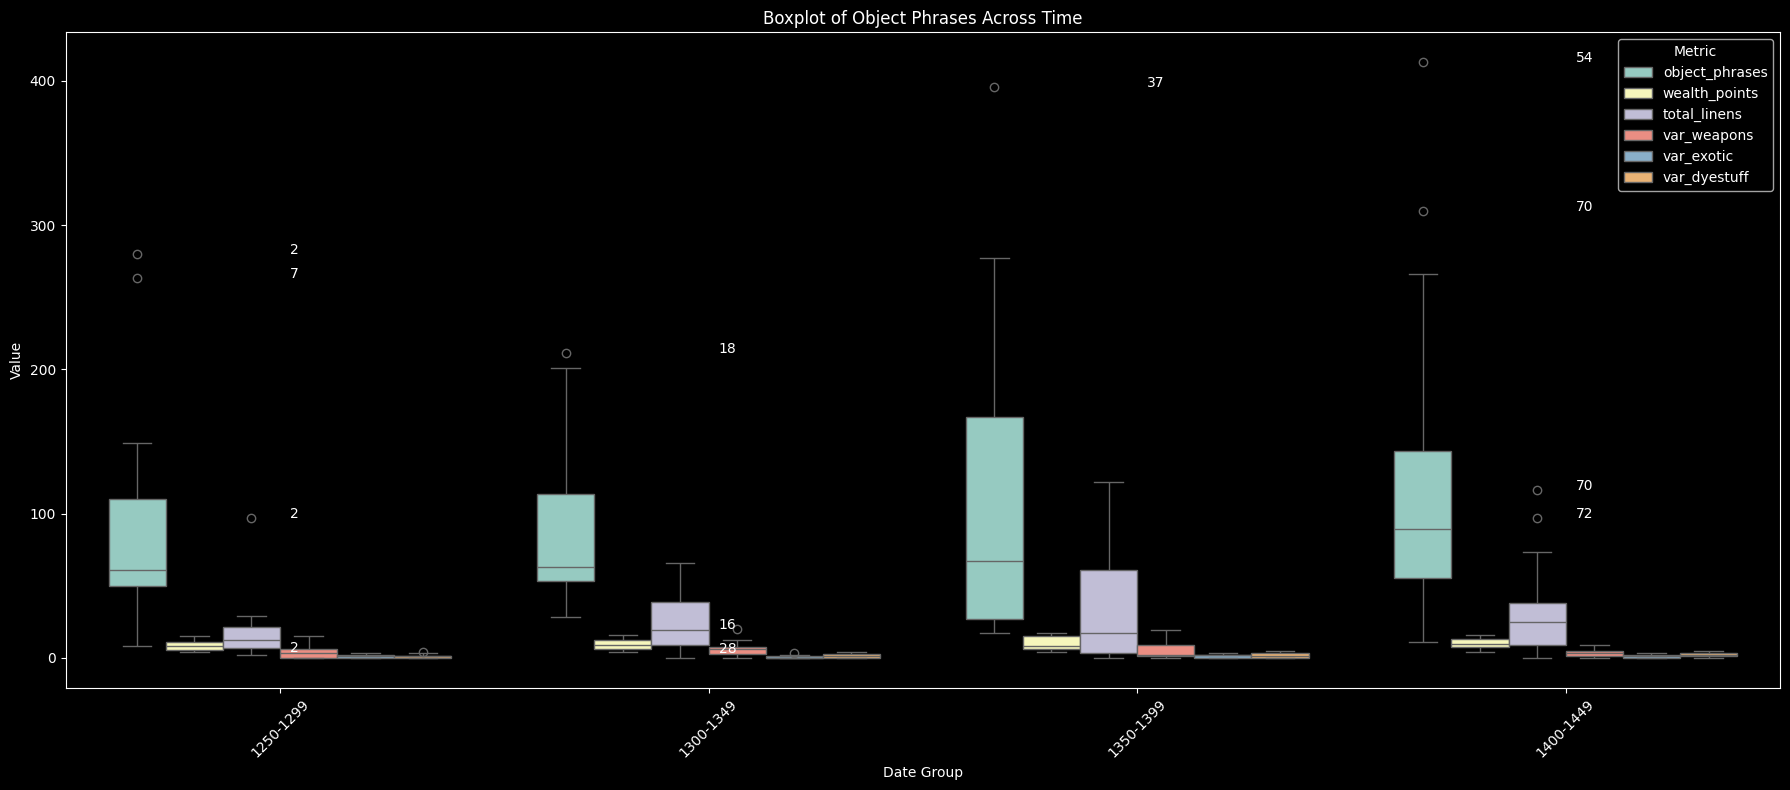

In [44]:
plt.figure(figsize=(18, 8))

plot_data = df.melt(
    id_vars=['id', 'date_group'],
    value_vars=['object_phrases', 'wealth_points', 'total_linens', 'var_weapons', 'var_exotic', 'var_dyestuff'],
    var_name='Metric',
    value_name='Value',
)

sns.boxplot(
    data=plot_data,
    x='date_group',
    y='Value',
    palette='Set3',
    hue='Metric',
)
plt.title('Boxplot of Object Phrases Across Time')
plt.xlabel('Date Group')
plt.ylabel('Value')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Add outlier labels
for metric in ['object_phrases', 'wealth_points', 'total_linens', 'var_weapons', 'var_exotic', 'var_dyestuff']:
    for group in DATE_GROUPINGS:
        df_group = df[df['date_group'] == group]
        for i, row in df_group.iterrows():  # noqa: B007
            if row[metric] > df_group[metric].quantile(0.75) + 1.5 * (
                df_group[metric].quantile(0.75) - df_group[metric].quantile(0.25)
            ):
                x_offset = 10
                plt.annotate(
                    str(row['id']),
                    xy=(row['date_group'], row[metric]),
                    xytext=(x_offset, 0),
                    textcoords='offset pixels',
                    fontsize=10,
                )


plt.show()

# results = plot_data.groupby(['date_group', 'Metric'])['Value'].describe()
# display(results)


## Interpretation

1250-1299: High variability in object_phrases and total_linens, indicating diverse inventories. wealth_points show low variability, suggesting consistent wealth distribution.
1300-1349: Decreased variability in most metrics, reflecting more uniform inventories and wealth distribution.
1350-1399: Peak variability in object_phrases, total_linens, and wealth_points, indicating significant diversity and economic disparities.
1400-1449: Stabilization of variability in wealth_points and total_linens, suggesting economic recovery or consolidation. High variability in object_phrases persists, reflecting continued diversity in inventories.

Object Phrases (object_phrases):

1250-1299: Mean = 97.45, Std = 93.45. High variability with a wide range (8 to 280), indicating diverse household inventories.
1300-1349: Mean = 91.73, Std = 59.43. Variability decreases compared to the previous period, suggesting more uniform inventories.
1350-1399: Mean = 107.95, Std = 104.82. Variability peaks, reflecting significant diversity in household inventories.
1400-1449: Mean = 114.84, Std = 87.99. Variability remains high, but slightly less than the previous period.

Wealth Points (wealth_points):

1250-1299: Mean = 8.36, Std = 3.78. Low variability, indicating consistent wealth distribution.
1300-1349: Mean = 9.36, Std = 3.74. Similar variability to the previous period.
1350-1399: Mean = 9.62, Std = 4.60. Variability increases, reflecting greater economic disparities.
1400-1449: Mean = 10.06, Std = 3.74. Variability stabilizes, suggesting economic recovery or consolidation.

Total Linens (total_linens):

1250-1299: Mean = 20.64, Std = 26.69. High variability, indicating diverse textile inventories.
1300-1349: Mean = 24.18, Std = 19.77. Variability decreases, suggesting more uniform textile inventories.
1350-1399: Mean = 31.48, Std = 35.92. Variability peaks, reflecting significant diversity in textile inventories.
1400-1449: Mean = 28.63, Std = 26.94. Variability decreases but remains relatively high.

Other Metrics (var_dyestuff, var_exotic, var_weapons):

Dyestuffs: Variability increases over time, peaking in 1400-1449 (Mean = 2.03, Std = 1.64).
Exotic Objects: Variability remains relatively low across all periods.
Weapons: Variability peaks in 1350-1399 (Mean = 5.29, Std = 6.14), then decreases in 1400-1449.


In [ ]:
# Calculate correlation coefficients and p-values for object groups
obj_groups = {
    'Dyestuffs': DYESTUFF_COLS,
    'Weapons and Armor': WEAPONS_AND_ARMOR_COLS,
    'Cushions': CUSHIONS_COLS,
    'Exotic Objects': EXOTIC_COLS,
    'Common Objects': OTHER_OBJECTS_COLS,
    'Linens': LINEN_COLS,
}

for group_name, group_columns in obj_groups.items():
    columns_to_analyze = group_columns
    correlation_results = []

    # Individual correlations
    for col in columns_to_analyze:
        corr, p_value = pearsonr(df[col], df['object_phrases'])
        correlation_results.append({'column': col, 'correlation': corr, 'p_value': p_value})

    # Convert results to DataFrame
    correlation_df = pd.DataFrame(correlation_results)

    # Visualize correlation results
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), width_ratios=[3, 1])
    sns.barplot(data=correlation_df, x='column', y='correlation', palette='viridis', ci='sd', ax=ax1)

    for index, row in correlation_df.iterrows():
        ax1.text(index, row['correlation'], f'{row["correlation"]:.2f}', ha='center', va='bottom')

    ax1.set_title(f'Correlation Between Number of Object Phrases and Presence of {group_name}')
    ax1.set_ylabel('Correlation Coefficient')
    ax1.set_xlabel(None)
    ax1.set_xticklabels(correlation_df['column'], rotation=45)
    sns.heatmap(
        correlation_df.pivot_table(index='column', values='p_value'),
        annot=True,
        cmap='coolwarm',
        cbar_kws={'label': 'P-Value'},
        ax=ax2,
    )
    ax2.set_title(f'P-Value Heatmap for {group_name} Correlations')
    ax2.set_xlabel(None)
    ax2.set_ylabel(None)
    plt.tight_layout()
    plt.show()


In [ ]:
# Calculate correlation coefficients and p-values for total_tablecloths, total_bedsheets, and total_tunics
columns_to_analyze = ['total_tablecloths', 'total_bedsheets', 'total_tunics']
correlation_results = []

# Individual correlations
for col in columns_to_analyze:
    corr, p_value = pearsonr(df[col], df['object_phrases'])
    correlation_results.append({'column': col, 'correlation': corr, 'p_value': p_value})

# Combined correlation (sum of the three columns)
df['combined_linens'] = df['total_tablecloths'] + df['total_bedsheets'] + df['total_tunics']
corr, p_value = pearsonr(df['combined_linens'], df['object_phrases'])
correlation_results.append({'column': 'combined_linens', 'correlation': corr, 'p_value': p_value})

# Convert results to DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Visualize correlation results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), width_ratios=[3, 1])
sns.barplot(data=correlation_df, x='column', y='correlation', palette='viridis', ci='sd', ax=ax1)

for index, row in correlation_df.iterrows():
    ax1.text(index, row['correlation'], f'{row["correlation"]:.2f}', ha='center', va='bottom')

ax1.set_title('Correlation Between Number of Object Phrases and Quantity of Linens')
ax1.set_ylabel('Correlation Coefficient')
ax1.set_xlabel(None)
ax1.set_xticklabels(correlation_df['column'])
sns.heatmap(
    correlation_df.pivot_table(index='column', values='p_value'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'P-Value'},
    ax=ax2,
)
ax2.set_title('P-Value Heatmap for Linen Correlations')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
plt.tight_layout()
plt.show()


### Interpretation

The analysis shows that textiles, particularly tablecloths and bedsheets, are strong indicators of household wealth *as measured by the number of object phrases in an inventory*. Tunics have a weaker but still significant association. The combined measure of textiles provides the strongest and most statistically significant correlation, reinforcing the idea that textiles as a group are closely tied to the number of object phrases in an inventory.

**Tablecloths:**
- *Correlation:* 0.701 (strong positive correlation)
- *P-value:* 5.58e-14 (highly statistically significant)
- The presence and quantity of tablecloths is strongly and significantly associated with the number of object phrases.

**Bedsheets:**
- *Correlation:* 0.656 (strong positive correlation)
- *P-value:* 7.10e-12 (highly statistically significant)
- The presence and quantity of bedsheets is also strongly and significantly associated with the number of object phrases, though slightly less so than tablecloths.

**Tunics:**
- *Correlation:* 0.250 (weak to moderate positive correlation)
- *P-value:* 2.05e-02 (statistically significant)
- The presence of tunics has a weaker but still significant positive association with the number of object phrases.

**Combined Textiles (sum of tablecloths, bedsheets, and tunics):**
- *Correlation:* 0.733 (strong positive correlation)
- *P-value:* 9.90e-16 (extremely statistically significant)
- When considering all textiles together, the correlation with the number of object phrases is even stronger, suggesting that these metrics are a robust indicator of wealth.

## Do these correlations hold across all time intervals?


In [ ]:
# Repeat the textile correlation analysis for each time interval
interval_correlation_results = []
for group, year_range in DATE_GROUPINGS.items():
    interval_data = df[df['year'].isin(year_range)]
    for col in [*columns_to_analyze, 'combined_textiles']:
        if not interval_data.empty:
            corr, p_value = pearsonr(interval_data[col], interval_data['object_phrases'])
            interval_correlation_results.append(
                {
                    'date_group': group,
                    'column': col,
                    'correlation': corr,
                    'p_value': p_value,
                },
            )

# Convert results to DataFrame
interval_correlation_df = pd.DataFrame(interval_correlation_results)

# Visualize results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.barplot(
    data=interval_correlation_df,
    x='date_group',
    y='correlation',
    hue='column',
    palette='viridis',
    ax=ax1,
    dodge=True,
)
ax1.set_title('Clustered Bar Chart: Correlation by Textile Type and Date Group')
ax1.set_xlabel(None)
ax1.set_ylabel('Correlation Coefficient')
ax1.legend(title='Textile Type', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.heatmap(
    interval_correlation_df.pivot(index='date_group', columns='column', values='correlation'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
    fmt='.2f',
    linewidths=0.5,
    linecolor='gray',
    square=True,
    mask=interval_correlation_df.pivot(index='date_group', columns='column', values='correlation').isnull(),
    annot_kws={'size': 8},
)
ax2.set_title('Interval Correlation Heatmap: Textile Counts vs Object Phrases')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
plt.tight_layout()
plt.show()

# Facet Grid of Line Plots
facet_data = interval_correlation_df.copy()
facet_data['date_group'] = pd.Categorical(facet_data['date_group'], categories=DATE_GROUPINGS.keys(), ordered=True)
facet_grid = sns.FacetGrid(facet_data, col='column', col_wrap=2, height=3, aspect=1.5, sharey=True, sharex=True)
facet_grid.map(sns.lineplot, 'date_group', 'correlation', marker='o').add_legend()
facet_grid.set_titles(col_template='{col_name}')
facet_grid.set_axis_labels('Date Group', 'Correlation Coefficient')
facet_grid.fig.subplots_adjust(top=0.9)
facet_grid.fig.suptitle('Facet Grid of Correlation Trends by Textile Type and Date Group')
plt.show()

# Radar charts
grid_data = interval_correlation_df.pivot(index='date_group', columns='column', values='correlation')
categories = grid_data.columns.tolist()

fig, axes = plt.subplots(2, 2, subplot_kw={'polar': True}, figsize=(10, 8))
axes = axes.flatten()
for date_group, ax in zip(grid_data.index, axes):
    values = grid_data.loc[date_group].fillna(0).tolist()
    values += values[:1]  # Close the radar chart
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=date_group)
    ax.fill(angles, values, alpha=0.3)
    ax.set_title(f'{date_group}', size=12, y=1.1)

plt.tight_layout()
plt.suptitle('Radar Charts: Correlation by Textile Type and Date Group', size=16, y=1.05)
plt.show()


### Interpretation

Tablecloths and bedsheets consistently show strong positive correlations with wealth, *as measured by the number of object phrases in an inventory*, across all time intervals. Tunics have weaker and less consistent correlations, with a negative trend in the 1400-1449 period. Combined textiles provide the strongest and most consistent correlation with the number of object phrases in an inventory. This is particularly true for the period between 1350-1399, perhaps hinting at the change in *object grouping* behaviour observed around 1400.

**Key findings by time interval:**

**1250-1299**
- Tablecloths: Strong positive correlation (0.801), statistically significant (p = 0.003).
- Bedsheets: Strong positive correlation (0.799), statistically significant (p = 0.003).
- Tunics: Moderate positive correlation (0.452), not statistically significant (p = 0.163).
- Combined Textiles: Strong positive correlation (0.817), statistically significant (p = 0.002).
- Tablecloths and bedsheets are strongly correlated to the number of object phrases in this period, while tunics show a weaker and non-significant relationship.

**1300-1349**
- Tablecloths: Strong positive correlation (0.645), statistically significant (p = 0.001).
- Bedsheets: Strong positive correlation (0.713), statistically significant (p < 0.001).
- Tunics: Moderate positive correlation (0.516), statistically significant (p = 0.014).
- Combined Textiles: Strong positive correlation (0.748), statistically significant (p < 0.001).
- All textile types, including tunics, show significant positive correlations with the number of object phrases, with combined textiles being the strongest indicator.

**1350-1399**
- Tablecloths: Very strong positive correlation (0.827), highly significant (p < 0.001).
- Bedsheets: Strong positive correlation (0.787), highly significant (p < 0.001).
- Tunics: Moderate positive correlation (0.533), statistically significant (p = 0.013).
- Combined Textiles: Very strong positive correlation (0.838), highly significant (p < 0.001).
- This period shows the strongest correlations overall, with tablecloths and combined textiles being particularly strong indicators.

**1400-1449**
- Tablecloths: Strong positive correlation (0.623), statistically significant (p < 0.001).
- Bedsheets: Moderate positive correlation (0.455), statistically significant (p = 0.009).
- Tunics: Weak negative correlation (-0.141), not statistically significant (p = 0.441).
- Combined Textiles: Strong positive correlation (0.596), statistically significant (p < 0.001).
- Tablecloths and combined textiles remain strongly correlated to the number of object phrases, while tunics show no significant relationship and even a slight negative trend.
